<a href="https://colab.research.google.com/github/ProgramasParaFisicaDeParticulas/lecturadedatosabiertoscmszmumu-Art-999/blob/main/CMSOpenDataZtoMuMu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## How were these data selected?

An event was selected if there were two muons in the event with pT > 20 GeV and |eta| < 2.1 and the invariant mass of the two muons was > 60 GeV and < 120 GeV.

In [95]:
#pandas nos permite manipular el archivo csv https://pandas.pydata.org
import pandas as pd
#numpy nos permite hacer operaciones usando vectores https://numpy.org
import numpy as np
#plotly nos permite crear graficas interactivas https://plotly.com/python/
import plotly.express as px

import matplotlib.pyplot as plt

%matplotlib inline

#usamos la liga que está directamente en la página.
particles = pd.read_csv('https://opendata.cern.ch/record/5208/files/Zmumu.csv',delimiter=',')


'''
Run: 	  The run number of the event.
Event: 	The event number.
pt: 	  The transverse momentum of the muon (GeV).
eta: 	  The pseudorapidity of the muon.
phi: 	  The phi angle of the muon (rad).
Q: 	    The charge of the muon.
dxy:	  The impact parameter in the transverse plane with respect to the vertex of the muon.    Distance like radius
iso: 	  The combined isolation (Itrack + Iecal + Ihcal) of the muon.                            Energy

Comparacion con particle data group
'''


from IPython.display import display
display(particles.head()) 


,Run,Event,pt1,eta1,phi1,Q1,dxy1,iso1,pt2,eta2,phi2,Q2,dxy2,iso2
0,165617,74969122,54.7055,-0.4324,2.5742,1,-0.0745,0.4999,34.2464,-0.9885,-0.4987,-1,0.0712,3.4221
1,165617,75138253,24.5872,-2.0522,2.8666,-1,-0.0554,0.0000,28.5389,0.3852,-1.9912,1,0.0515,0.0000
2,165617,75887636,31.7386,-2.2595,-1.3323,-1,0.0879,0.0000,30.2344,-0.4684,1.8833,1,-0.0876,0.0000
3,165617,75779415,39.7394,-0.7123,-0.3123,1,0.0585,0.0000,48.2790,-0.1956,2.9703,-1,-0.0492,0.0000
4,165617,75098104,41.2998,-0.1571,-3.0408,1,-0.0305,1.2280,43.4508,0.5910,-0.0428,-1,0.0442,0.0000


# Ajuste con la distribución Breit-Weigner

In [96]:
from lmfit import Model

def breit_wigner_lineal(x, A, M, gamma, m, b):
    '''
    x: la masa invariante
    A: cte de normalización
    m, b: parametros de ajuste lineal
    gamma: Hip. anchura
    '''
    return A * (M**2 * gamma**2) / ((x**2 - M**2)**2 + (M * gamma)**2) + m*x + b

model = Model(breit_wigner_lineal)


# Distribución de masa invariante original

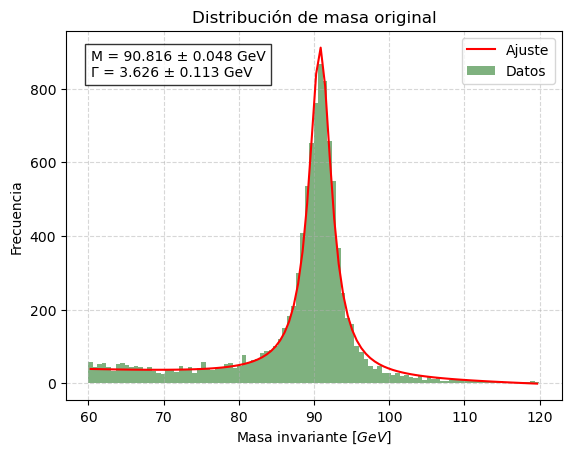

[[Model]]
    Model(breit_wigner_lineal)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 100
    # variables        = 5
    chi-square         = 251.760281
    reduced chi-square = 2.65010822
    Akaike info crit   = 102.330718
    Bayesian info crit = 115.356569
    R-squared          = 0.98899942
[[Variables]]
    A:      898.671804 +/- 28.0320204 (3.12%) (init = 868)
    M:      90.8163267 +/- 0.04765294 (0.05%) (init = 91.2)
    gamma:  3.62578083 +/- 0.11297086 (3.12%) (init = 2.5)
    m:     -0.63955113 +/- 0.04302194 (6.73%) (init = 0)
    b:      72.6817540 +/- 4.78114842 (6.58%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m, b)     = -0.9884
    C(A, gamma) = -0.7612
    C(gamma, b) = -0.3170
    C(gamma, m) = +0.2585


In [97]:
# Histograma de la masa invariante de los datos originales
# Masa del boson Z : 91.1880 \pm 0.0020 GeV
M_0 = np.sqrt(2*particles['pt1']*particles['pt2']*
              (np.cosh(particles['eta1'] - particles['eta2']) - np.cos(particles['phi1'] - particles['phi2'])))
M_0 = M_0[np.isfinite(M_0)]


frec, bin_edges = np.histogram(M_0, bins=100)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

#Parametros para el ajuste
params = model.make_params(A=max(frec), M=91.2, gamma=2.5,
                          m=0, b=0)
params['M'].set(min=60, max=120)
params['gamma'].set(min=0.1, max=5) 
W = np.where(frec > 0, 1/np.sqrt(frec), 0)

ajuste = model.fit(frec, params, x = bin_centers, weights=W)

plt.bar(bin_centers, frec, width=bin_edges[1]-bin_edges[0], alpha=0.5, color = 'darkgreen', label='Datos')
plt.plot(bin_centers, ajuste.best_fit, 'r-', label='Ajuste')
plt.xlabel(r"Masa invariante [$GeV$]")
plt.ylabel("Frecuencia")
plt.title("Distribución de masa original")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Add fit parameters to plot
fit_text = (
    f"M = {ajuste.params['M'].value:.3f} ± {ajuste.params['M'].stderr:.3f} GeV\n"
    f"Γ = {ajuste.params['gamma'].value:.3f} ± {ajuste.params['gamma'].stderr:.3f} GeV"
)
plt.text(0.05, 0.95, fit_text, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
plt.show()

'''
plt.hist(M_0, bins=200, label='Masa', color='darkgreen')
plt.xlabel(r"Masa invariante [$GeV$]")
plt.ylabel("Frecuencia")
plt.title("Distribución de masa original")
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()


#hist_MO = px.histogram(M)
#hist_MO.show()
'''
# Print fit report
print(ajuste.fit_report())

# Pseudorapidez

### The effect of pseudorapidity to the resolution of the measurement

With the CMS detector for example momenta of particles can be measured. Pseudorapidity

affects to the resolution of the measurement of momenta. The particles that hit in the middle part of the detector (in the barrel) can be measured more accurate than the particles that hit in the end of the detector (in the endcap).

The reason for that is probably that the particles that have flown to the endcap have encountered more other matter (other particles) than the particles hit in the barrel. The interaction with other matter will cause inaccuracy to the measurements of the particles hit in the endcap.

In the image below there is a draft of the two particles created in the collision event. One hits the barrel of the detector and another hits the endcap. There are also the values of pseudorapidities
and the angles of the particles.

<img src="../imgs/Sylinder.png" alt="Draft of the CMS detector" style="height: 300px">
Por eso mismo en la base de datos indica que |eta| < 2.1

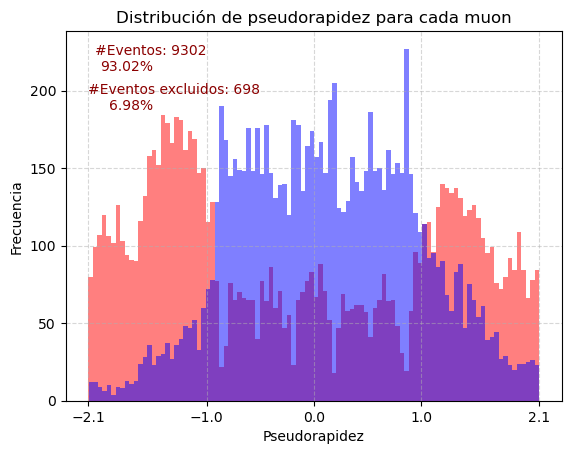

In [98]:
### Histograma

xticks = np.array([-2.1, -1, 0, 1, 2.1])
'''
plt.hist(particles_f['eta1'], bins=100, alpha=0.5, label='pt1', color='red')
plt.hist(particles_f['eta2'], bins=100, alpha=0.5, label='pt1', color='blue')
plt.xlabel('Pseudorapidez')
plt.ylabel("Frecuencia")
plt.xticks(xticks)
plt.title("Distribución de pseudorapidez para cada muon")
plt.grid(True, linestyle='--', alpha=0.5)

plt.savefig("pseudo_distribution_ini.png", dpi=300, bbox_inches='tight') 
plt.show()
'''


mask_eta = (np.abs(particles['eta1'])< 2.1) & (np.abs(particles['eta2'])< 2.1)
corte_eta = particles[mask_eta].copy()

plt.hist(corte_eta['eta1'], bins=100, alpha=0.5, label='pt1', color='red')
plt.hist(corte_eta['eta2'], bins=100, alpha=0.5, label='pt1', color='blue')
plt.xlabel('Pseudorapidez')
plt.ylabel("Frecuencia")
plt.xticks(xticks)
plt.title("Distribución de pseudorapidez para cada muon")
plt.grid(True, linestyle='--', alpha=0.5)

plt.text(-1, 230, '#Eventos: ' + str(len(corte_eta)) , rotation=0, 
         va='top', ha='right', color='darkred')
plt.text(-1.5, 220, str(100 -(10000 -len(corte_eta))/100) + '%' , rotation=0, 
         va='top', ha='right', color='darkred')
plt.text(-0.5, 205, '#Eventos excluidos: ' + str(10000 -len(corte_eta)) , rotation=0, 
         va='top', ha='right', color='darkred')
plt.text(-1.5, 195, str((10000 -len(corte_eta))/100) + '%' , rotation=0, 
         va='top', ha='right', color='darkred')
plt.grid(True, linestyle='--', alpha=0.5)


plt.savefig("pseudo_distribution.png", dpi=300, bbox_inches='tight') 
plt.show()

# Masa invariante corte eta

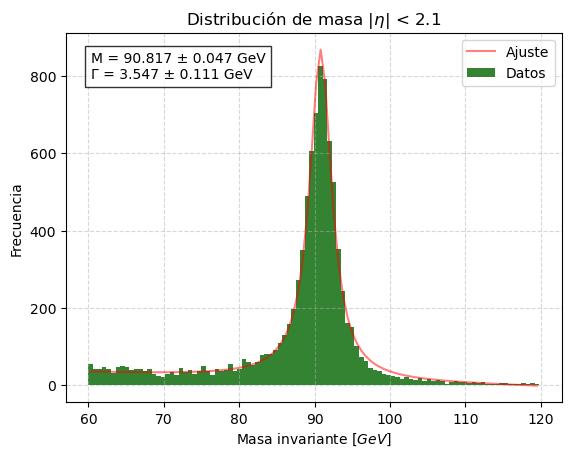

In [99]:
M_1 = np.sqrt(2*corte_eta['pt1']*corte_eta['pt2']*
              (np.cosh(corte_eta['eta1'] - corte_eta['eta2']) - np.cos(corte_eta['phi1'] - corte_eta['phi2'])))
M_1 = M_1[np.isfinite(M_1)]


frec, bin_edges = np.histogram(M_1, bins=100)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

#Parametros para el ajuste
params = model.make_params(A=max(frec), M=91.2, gamma=2.5,
                          m=0, b=0)
params['M'].set(min=60, max=120)
params['gamma'].set(min=0.1, max=5) 
W = np.where(frec > 0, 1/np.sqrt(frec), 0)

ajuste = model.fit(frec, params, x = bin_centers, weights=W)

plt.bar(bin_centers, frec, width=bin_edges[1]-bin_edges[0], alpha=0.8, color = 'darkgreen', label='Datos')
plt.plot(bin_centers, ajuste.best_fit, 'r-', label='Ajuste', alpha=0.5)
plt.xlabel(r"Masa invariante [$GeV$]")
plt.ylabel("Frecuencia")
plt.title(r"Distribución de masa $|\eta|$ < 2.1")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Add fit parameters to plot
fit_text = (
    f"M = {ajuste.params['M'].value:.3f} ± {ajuste.params['M'].stderr:.3f} GeV\n"
    f"Γ = {ajuste.params['gamma'].value:.3f} ± {ajuste.params['gamma'].stderr:.3f} GeV"
)
plt.text(0.05, 0.95, fit_text, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
plt.show()

# Carga

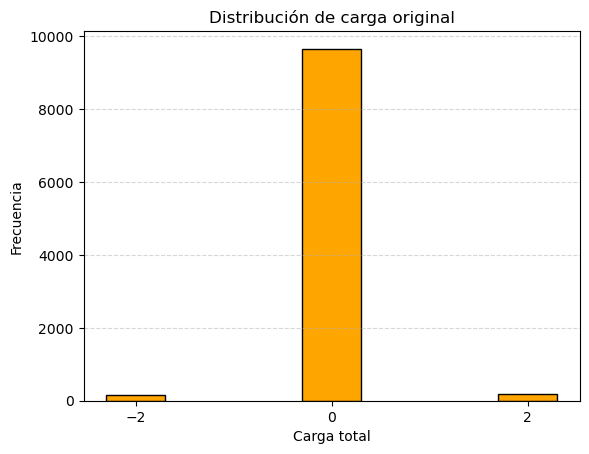

In [100]:
# Histograma de Carga

'''
Histogramas de las cargas del dataframe OG

plt.hist(Q1, bins=10, alpha=0.5, label='Q1', color='blue')
plt.hist(Q2, bins=10, alpha=0.5, label='Q2', color='red')
plt.show()


Hist_Q_= px.histogram(Q)
#Hist_Q_.show()
'''
valor_carga, frec = np.unique(particles['Q1'] + particles['Q2'], return_counts=True)


plt.bar(valor_carga, frec, width=0.6, color='orange', edgecolor='black')

plt.xlabel("Carga total")
plt.ylabel("Frecuencia")
plt.title("Distribución de carga original")

plt.xticks([-2, 0, 2])
plt.grid(axis='y', linestyle='--', alpha=0.5)


plt.savefig("charge_distribution_inicial.png", dpi=300, bbox_inches='tight') 
plt.show()


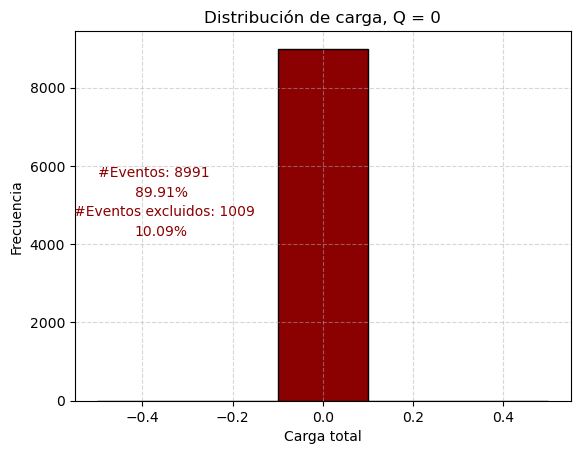

In [101]:
mask_Q = particles['Q1'] + particles['Q2']==0
corte_Q = particles[mask_Q & mask_eta].copy()


plt.hist(corte_Q['Q1'] + corte_Q['Q2'], bins=5, label='Carga Total', color='darkred', edgecolor='black')
plt.xlabel("Carga total")
plt.ylabel("Frecuencia")
plt.title("Distribución de carga, Q = 0")
plt.text(-0.25, 6000, '#Eventos: ' + str(len(corte_Q)) , rotation=0, 
         va='top', ha='right', color='darkred')
plt.text(-0.3, 5500, str(100 -(10000 -len(corte_Q))/100) + '%' , rotation=0, 
         va='top', ha='right', color='darkred')
plt.text(-0.15, 5000, '#Eventos excluidos: ' + str(10000 -len(corte_Q)) , rotation=0, 
         va='top', ha='right', color='darkred')
plt.text(-0.3, 4500, str((10000 -len(corte_Q))/100) + '%' , rotation=0, 
         va='top', ha='right', color='darkred')
plt.grid(True, linestyle='--', alpha=0.5)


plt.savefig("charge_distribution.png", dpi=300, bbox_inches='tight') 
plt.show()


# Masa invariante corte Q = 0

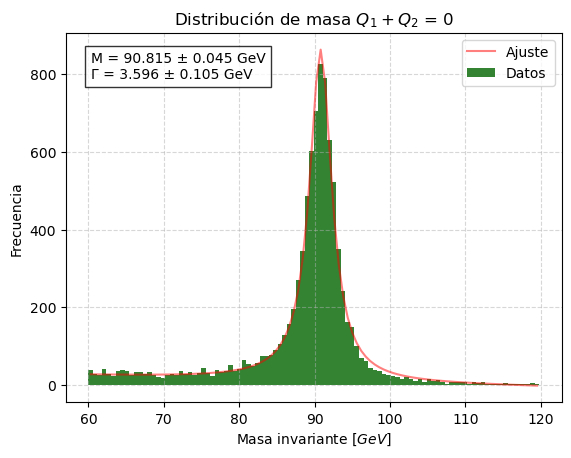

In [102]:
M_2 = np.sqrt(2*corte_Q['pt1']*corte_Q['pt2']*
              (np.cosh(corte_Q['eta1'] - corte_Q['eta2']) - np.cos(corte_Q['phi1'] - corte_Q['phi2'])))
M_2 = M_2[np.isfinite(M_2)]


frec, bin_edges = np.histogram(M_2, bins=100)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

#Parametros para el ajuste
params = model.make_params(A=max(frec), M=91.2, gamma=2.5,
                          m=0, b=0)
params['M'].set(min=60, max=120)
params['gamma'].set(min=0.1, max=5) 
W = np.where(frec > 0, 1/np.sqrt(frec), 0)

ajuste = model.fit(frec, params, x = bin_centers, weights=W)

plt.bar(bin_centers, frec, width=bin_edges[1]-bin_edges[0], alpha=0.8, color = 'darkgreen', label='Datos')
plt.plot(bin_centers, ajuste.best_fit, 'r-', label='Ajuste', alpha=0.5)
plt.xlabel(r"Masa invariante [$GeV$]")
plt.ylabel("Frecuencia")
plt.title(r"Distribución de masa $Q_1 + Q_2$ = 0")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Add fit parameters to plot
fit_text = (
    f"M = {ajuste.params['M'].value:.3f} ± {ajuste.params['M'].stderr:.3f} GeV\n"
    f"Γ = {ajuste.params['gamma'].value:.3f} ± {ajuste.params['gamma'].stderr:.3f} GeV"
)
plt.text(0.05, 0.95, fit_text, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
plt.show()

# Momento Transversal

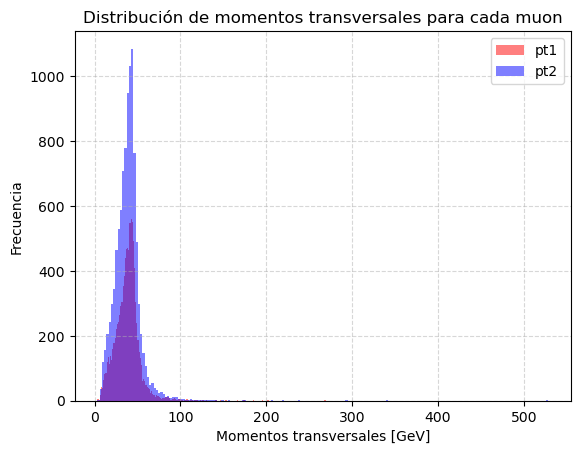

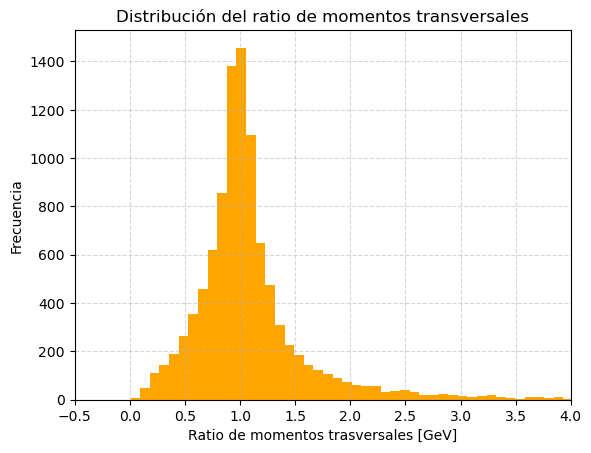

In [103]:
# Histograma de momento transversal

ratio_pt = particles['pt1']/particles['pt2']

plt.hist(particles['pt1'], bins=200, alpha=0.5, label='pt1', color='red')
plt.hist(particles['pt2'], bins=200, alpha=0.5, label='pt2', color='blue')
plt.xlabel("Momentos transversales [GeV]")
plt.ylabel("Frecuencia")
plt.title("Distribución de momentos transversales para cada muon")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

plt.hist(ratio_pt, bins=200, alpha=1, color='orange')
plt.xlabel("Ratio de momentos trasversales [GeV]")
plt.ylabel("Frecuencia")
plt.title("Distribución del ratio de momentos transversales")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(-0.5, 4)

plt.savefig("dpt_distribution_inicial.png", dpi=300, bbox_inches='tight') 
plt.show()

#fig_dpt.show()


 Qué tan preciso tiene que ser la conservacion del momento? pt1/pt2 = 1 +/- ??? 

 
 En que intervalo cae la mayoria de los datos, digamos 75%?

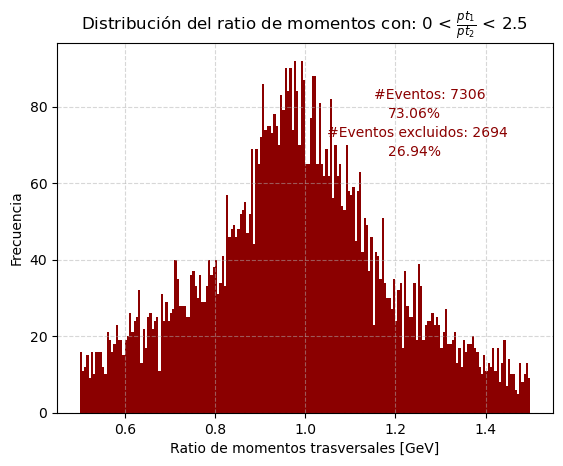

In [104]:
#Voy a considerar 0 < pt1/pt2 < 5
mask_pt = (ratio_pt >= 0.5) & (ratio_pt <= 1.5)
corte_pt = particles[mask_pt & mask_Q & mask_eta].copy()

plt.hist(corte_pt['pt1']/corte_pt['pt2'], bins=200, label='dpt', color='darkred')
plt.xlabel("Ratio de momentos trasversales [GeV]")
plt.ylabel("Frecuencia")
plt.title(r"Distribución del ratio de momentos con: 0 < $\frac{pt_1}{pt_2}$ < 2.5")
plt.grid(True, linestyle='--', alpha=0.5)

plt.text(1.4, 85, '#Eventos: ' + str(len(corte_pt)) , rotation=0, 
         va='top', ha='right', color='darkred')
plt.text(1.3, 80, str(100-(10000 -len(corte_pt))/100) + '%' , rotation=0, 
         va='top', ha='right', color='darkred')
plt.text(1.45, 75, '#Eventos excluidos: ' + str(10000 -len(corte_pt)) , rotation=0, 
         va='top', ha='right', color='darkred')
plt.text(1.3, 70, str((10000 -len(corte_pt))/100) + '%' , rotation=0, 
         va='top', ha='right', color='darkred')
         
plt.grid(True, linestyle='--', alpha=0.5)

plt.savefig("dpt_distribution.png", dpi=300, bbox_inches='tight') 
plt.show()


# Masa invariante corte ratio pt

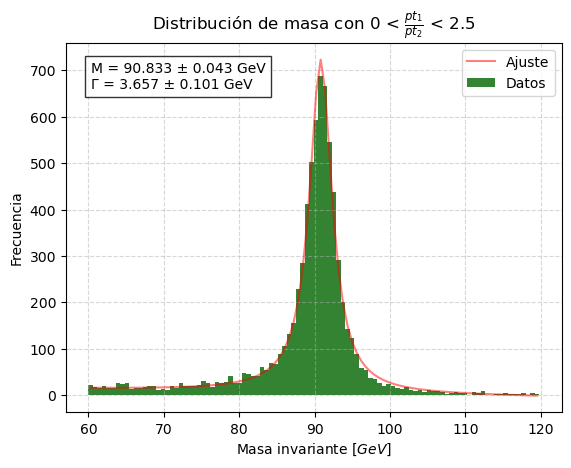

In [105]:
M_3 = np.sqrt(2*corte_pt['pt1']*corte_pt['pt2']*
              (np.cosh(corte_pt['eta1'] - corte_pt['eta2']) - np.cos(corte_pt['phi1'] - corte_pt['phi2'])))
M_3 = M_3[np.isfinite(M_3)]


frec, bin_edges = np.histogram(M_3, bins=100)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

#Parametros para el ajuste
params = model.make_params(A=max(frec), M=91.2, gamma=2.5,
                          m=0, b=0)
params['M'].set(min=60, max=120)
params['gamma'].set(min=0.1, max=5) 
W = np.zeros_like(frec, dtype=float)  
mask = frec > 0
W[mask] = 1 / np.sqrt(frec[mask])

ajuste = model.fit(frec, params, x = bin_centers, weights=W)

plt.bar(bin_centers, frec, width=bin_edges[1]-bin_edges[0], alpha=0.8, color = 'darkgreen', label='Datos')
plt.plot(bin_centers, ajuste.best_fit, 'r-', label='Ajuste', alpha=0.5)
plt.xlabel(r"Masa invariante [$GeV$]")
plt.ylabel("Frecuencia")
plt.title(r"Distribución de masa con 0 < $\frac{pt_1}{pt_2}$ < 2.5")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Add fit parameters to plot
fit_text = (
    f"M = {ajuste.params['M'].value:.3f} ± {ajuste.params['M'].stderr:.3f} GeV\n"
    f"Γ = {ajuste.params['gamma'].value:.3f} ± {ajuste.params['gamma'].stderr:.3f} GeV"
)
plt.text(0.05, 0.95, fit_text, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
plt.show()

# Isolation

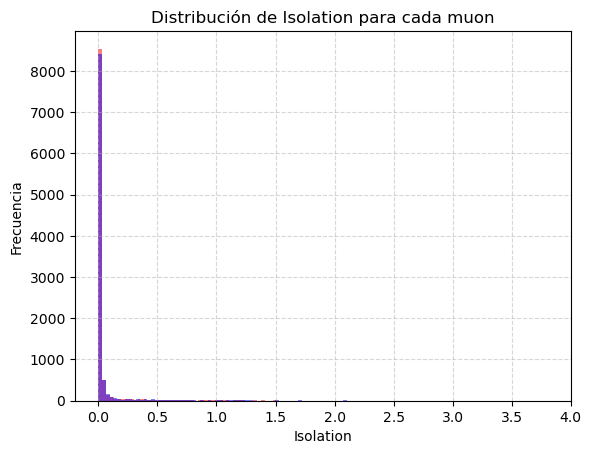

In [119]:
# Histograma de isolation: energía delECAL + HCAL + Itrack/ pt

rel_iso1 = particles['iso1']/particles['pt1']
rel_iso2 = particles['iso2']/particles['pt2']
plt.hist(rel_iso1, bins=250, alpha=0.5, label='pt1', color='red')
plt.hist(rel_iso2, bins=250, alpha=0.5, label='pt1', color='blue')
plt.xlabel('Isolation')
plt.ylabel("Frecuencia")
plt.title("Distribución de Isolation para cada muon")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(-0.2,4)
plt.show()


Mismo problema que la diferencia de momentos, sabemos que iso/pt es una razón entre la energía del muon y lo recolecado del ECAL, HCAL. Mientras más cercano a 0 se considera que es un muon, otros mas alejados a 0 son jets.

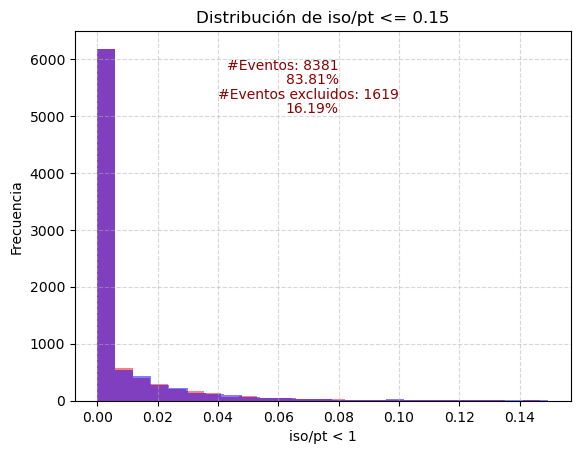

In [124]:
# Vamos a acotarlo de 0 - 1
mask_iso = (np.abs(rel_iso1) <= 0.15) & (np.abs(rel_iso2) <= 0.15)
corte_iso = particles[mask_iso & mask_eta & mask_Q].copy()

plt.hist(corte_iso['iso1']/corte_iso['pt1'], bins=25, alpha=0.5, label='iso1', color='red')
plt.hist(corte_iso['iso2']/corte_iso['pt2'], bins=25, alpha=0.5, label='iso2', color='blue')
plt.xlabel('iso/pt < 1')
plt.ylabel("Frecuencia")
plt.title("Distribución de iso/pt <= 0.15")
plt.grid(True, linestyle='--', alpha=0.5)

plt.text(0.08, 6000, '#Eventos: ' + str(len(corte_iso)) , rotation=0, 
         va='top', ha='right', color='darkred')
plt.text(0.08, 5750, str(100-(10000 -len(corte_iso))/100) + '%' , rotation=0, 
         va='top', ha='right', color='darkred')
plt.text(0.1, 5500, '#Eventos excluidos: ' + str(10000 -len(corte_iso)) , rotation=0, 
         va='top', ha='right', color='darkred')
plt.text(0.08, 5250, str((10000 -len(corte_iso))/100) + '%' , rotation=0, 
         va='top', ha='right', color='darkred')
         

plt.savefig("iso_distribution.png", dpi=300, bbox_inches='tight') 
plt.show()


# Masa invariante corte iso/pt

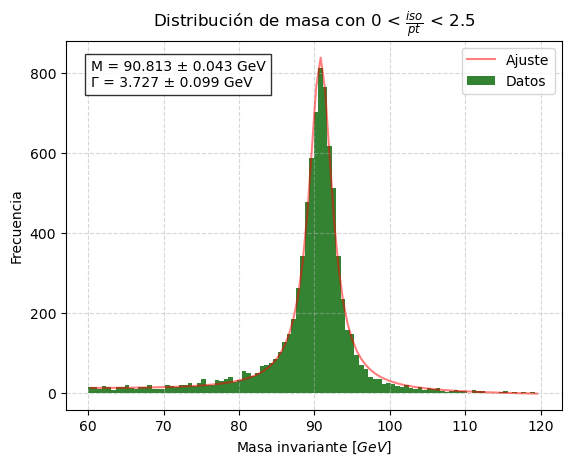

In [108]:
M_4 = np.sqrt(2*corte_iso['pt1']*corte_iso['pt2']*
              (np.cosh(corte_iso['eta1'] - corte_iso['eta2']) - np.cos(corte_iso['phi1'] - corte_iso['phi2'])))
M_4 = M_4[np.isfinite(M_4)]


frec, bin_edges = np.histogram(M_4, bins=100)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

#Parametros para el ajuste
params = model.make_params(A=max(frec), M=91.2, gamma=2.5,
                          m=0, b=0)
params['M'].set(min=60, max=120)
params['gamma'].set(min=0.1, max=5) 
W = np.where(frec > 0, 1/np.sqrt(frec), 0)

ajuste = model.fit(frec, params, x = bin_centers, weights=W)

plt.bar(bin_centers, frec, width=bin_edges[1]-bin_edges[0], alpha=0.8, color = 'darkgreen', label='Datos')
plt.plot(bin_centers, ajuste.best_fit, 'r-', label='Ajuste', alpha=0.5)
plt.xlabel(r"Masa invariante [$GeV$]")
plt.ylabel("Frecuencia")
plt.title(r"Distribución de masa con 0 < $\frac{iso}{pt}$ < 2.5")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Add fit parameters to plot
fit_text = (
    f"M = {ajuste.params['M'].value:.3f} ± {ajuste.params['M'].stderr:.3f} GeV\n"
    f"Γ = {ajuste.params['gamma'].value:.3f} ± {ajuste.params['gamma'].stderr:.3f} GeV"
)
plt.text(0.05, 0.95, fit_text, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
plt.show()

# Parametro de impacto

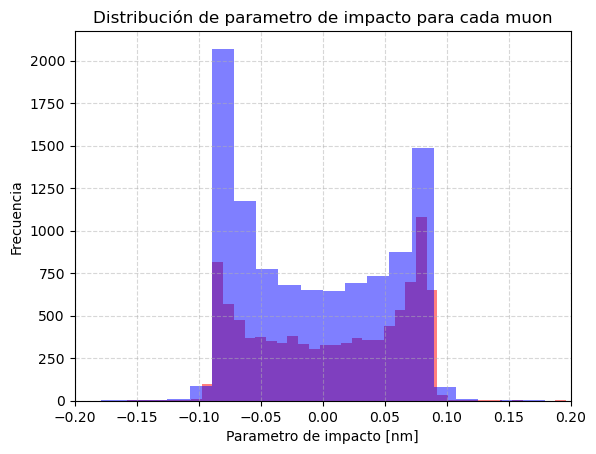

In [109]:
# Histograma de dxy


plt.hist(particles['dxy1'], bins=650, alpha=0.5, label='pt1', color='red')
plt.hist(particles['dxy2'], bins=10050, alpha=0.5, label='pt1', color='blue')
plt.xlabel('Parametro de impacto [nm]')
plt.ylabel("Frecuencia")
plt.title("Distribución de parametro de impacto para cada muon")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(-0.2, 0.2)
plt.show()


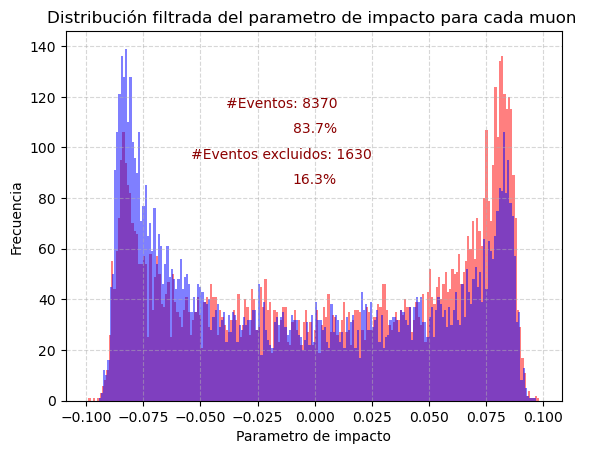

In [125]:
# Corte parametro de impacto < 0.1
mask_dxy = (particles['dxy1'].abs() < 0.1) & (particles['dxy2'].abs() < 0.1)
corte_dxy= particles[mask_dxy & mask_Q & mask_iso & mask_eta].copy()

plt.hist(corte_dxy['dxy1'], bins=200, alpha=0.5, label='dxy1', color='red')
plt.hist(corte_dxy['dxy2'], bins=200, alpha=0.5, label='dxy2', color='blue')
plt.xlabel('Parametro de impacto')
plt.ylabel("Frecuencia")
plt.title("Distribución filtrada del parametro de impacto para cada muon ")
plt.grid(True, linestyle='--', alpha=0.5)

plt.text(0.01, 120, '#Eventos: ' + str(len(corte_dxy)) , rotation=0, 
         va='top', ha='right', color='darkred')
plt.text(0, 110, str(100-(10000 -len(corte_dxy))/100) + '%' , rotation=0, 
         va='top', ha='center', color='darkred')
plt.text(0.025, 100, '#Eventos excluidos: ' + str(10000 -len(corte_dxy)) , rotation=0, 
         va='top', ha='right', color='darkred')
plt.text(0, 90, str((10000 -len(corte_dxy))/100) + '%' , rotation=0, 
         va='top', ha='center', color='darkred')

plt.savefig("dxy_distribution.png", dpi=300, bbox_inches='tight') 
plt.show()


# Masa invariante corte dxy

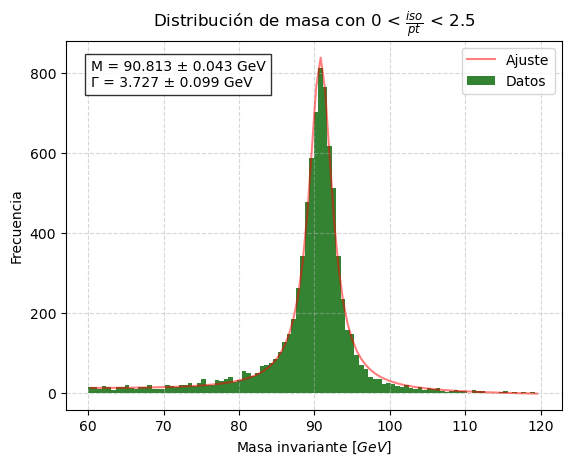

In [111]:
M_5 = np.sqrt(2*corte_dxy['pt1']*corte_dxy['pt2']*
              (np.cosh(corte_dxy['eta1'] - corte_dxy['eta2']) - np.cos(corte_dxy['phi1'] - corte_dxy['phi2'])))
M_4 = M_4[np.isfinite(M_4)]


frec, bin_edges = np.histogram(M_4, bins=100)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

#Parametros para el ajuste
params = model.make_params(A=max(frec), M=91.2, gamma=2.5,
                          m=0, b=0)
params['M'].set(min=60, max=120)
params['gamma'].set(min=0.1, max=5) 
W = np.where(frec > 0, 1/np.sqrt(frec), 0)

ajuste = model.fit(frec, params, x = bin_centers, weights=W)

plt.bar(bin_centers, frec, width=bin_edges[1]-bin_edges[0], alpha=0.8, color = 'darkgreen', label='Datos')
plt.plot(bin_centers, ajuste.best_fit, 'r-', label='Ajuste', alpha=0.5)
plt.xlabel(r"Masa invariante [$GeV$]")
plt.ylabel("Frecuencia")
plt.title(r"Distribución de masa con 0 < $\frac{iso}{pt}$ < 2.5")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Add fit parameters to plot
fit_text = (
    f"M = {ajuste.params['M'].value:.3f} ± {ajuste.params['M'].stderr:.3f} GeV\n"
    f"Γ = {ajuste.params['gamma'].value:.3f} ± {ajuste.params['gamma'].stderr:.3f} GeV"
)
plt.text(0.05, 0.95, fit_text, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
plt.show()

# Corte total y masa invariante final

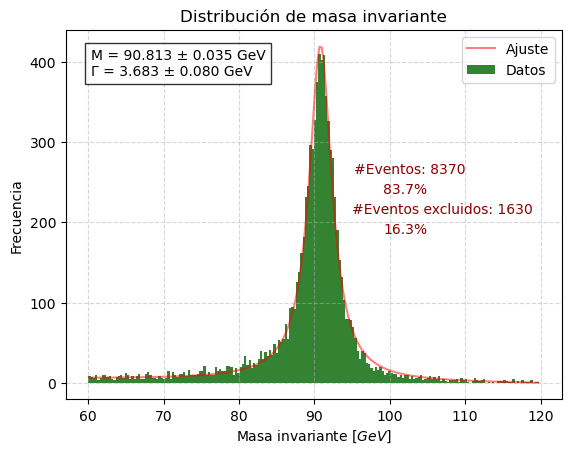

Error porcentual Masa: 0.41%
Error porcentual Gamma: 47.60%


In [126]:
corte_t = particles[(mask_eta) & (mask_iso) & (mask_dxy) & (mask_Q) ].copy()

M_T = np.sqrt(2*corte_t['pt1']*corte_t['pt2']*
              (np.cosh(corte_t['eta1'] - corte_t['eta2']) - np.cos(corte_t['phi1'] - corte_t['phi2'])))
M_T = M_T[np.isfinite(M_T)]


frec, bin_edges = np.histogram(M_T, bins=200)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

#Parametros para el ajuste
params = model.make_params(A=max(frec), M=91.2, gamma=2.5,
                          m=0, b=0)
params['M'].set(min=60, max=120)
params['gamma'].set(min=0.1, max=5) 

W = np.zeros_like(frec, dtype=float)  
mask = frec > 0
W[mask] = 1 / np.sqrt(frec[mask])

ajuste = model.fit(frec, params, x = bin_centers, weights=W)

plt.bar(bin_centers, frec, width=bin_edges[1]-bin_edges[0], alpha=0.8, color = 'darkgreen', label='Datos')
plt.plot(bin_centers, ajuste.best_fit, 'r-', label='Ajuste', alpha=0.5)
plt.xlabel(r"Masa invariante [$GeV$]")
plt.ylabel("Frecuencia")
plt.title(r"Distribución de masa invariante")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Add fit parameters to plot
fit_text = (
    f"M = {ajuste.params['M'].value:.3f} ± {ajuste.params['M'].stderr:.3f} GeV\n"
    f"Γ = {ajuste.params['gamma'].value:.3f} ± {ajuste.params['gamma'].stderr:.3f} GeV"
)
plt.text(0.05, 0.95, fit_text, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
plt.text(110, 275, '#Eventos: ' + str(len(corte_t)) , rotation=0, 
         va='top', ha='right', color='darkred')
plt.text(105, 250, str(100-(10000 -len(corte_t))/100) + '%' , rotation=0, 
         va='top', ha='right', color='darkred')
plt.text(119, 225, '#Eventos excluidos: ' + str(10000 -len(corte_t)) , rotation=0, 
         va='top', ha='right', color='darkred')
plt.text(105, 200, str((10000 -len(corte_t))/100) + '%' , rotation=0, 
         va='top', ha='right', color='darkred')

plt.savefig("mass_distribution_final.png", dpi=300, bbox_inches='tight') 
plt.show()

def error_porcentual(medido, real):
    return abs((medido - real) / real) * 100
MR = 91.1880
GammaR = 2.4955
errorM = error_porcentual(ajuste.params['M'].value, MR)
errorG = error_porcentual(ajuste.params['gamma'].value, GammaR)
print(f"Error porcentual Masa: {errorM:.2f}%")
print(f"Error porcentual Gamma: {errorG:.2f}%")

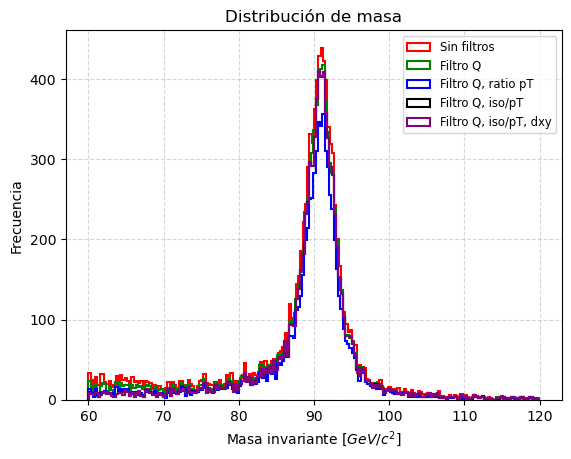

In [116]:
# Comparacion
mask_Q_eta = mask_Q & mask_eta
corte_Q_eta = particles[mask_Q_eta].copy()

M_1 = np.sqrt(2*corte_Q_eta['pt1']*corte_Q_eta['pt2']*
              (np.cosh(corte_Q_eta['eta1'] - corte_Q_eta['eta2']) - np.cos(corte_Q_eta['phi1'] - corte_Q_eta['phi2'])))

mask_Q_eta_pt = mask_Q_eta & mask_pt
corte_Q_eta_pt = particles[mask_Q_eta_pt].copy()

M_2 = np.sqrt(2*corte_Q_eta_pt['pt1']*corte_Q_eta_pt['pt2']*
              (np.cosh(corte_Q_eta_pt['eta1'] - corte_Q_eta_pt['eta2']) - np.cos(corte_Q_eta_pt['phi1'] - corte_Q_eta_pt['phi2'])))

mask_Q_eta_iso = mask_Q_eta & mask_iso
corte_Q_eta_iso = particles[mask_Q_eta_iso].copy()

M_3 = np.sqrt(2*corte_Q_eta_iso['pt1']*corte_Q_eta_iso['pt2']*
              (np.cosh(corte_Q_eta_iso['eta1'] - corte_Q_eta_iso['eta2']) - np.cos(corte_Q_eta_iso['phi1'] - corte_Q_eta_iso['phi2'])))
plt.hist(M_0, bins=200, label='Sin filtros', alpha = 1,
    facecolor='none',      # No fill
    edgecolor='red',    # Border color
    linewidth=1.5,        # Border thickness
    histtype='step'       # Optional: Creates a clean outlined histogram
        )
plt.hist(M_1, bins=200, label='Filtro Q', color='red', alpha = 1,
    facecolor='none',      # No fill
    edgecolor='green',    # Border color
    linewidth=1.5,        # Border thickness
    histtype='step'       # Optional: Creates a clean outlined histogram
        )
plt.hist(M_2, bins=200, label='Filtro Q, ratio pT', color='blue', alpha = 1,
    facecolor='none',      # No fill
    edgecolor='blue',    # Border color
    linewidth=1.5,        # Border thickness
    histtype='step'       # Optional: Creates a clean outlined histogram
        )
plt.hist(M_3, bins=200, label='Filtro Q, iso/pT', color='blue', alpha = 1,
    facecolor='none',      # No fill
    edgecolor='black',    # Border color
    linewidth=1.5,        # Border thickness
    histtype='step'       # Optional: Creates a clean outlined histogram
        )
plt.hist(M_T, bins=200, label='Filtro Q, iso/pT, dxy', alpha = 1,
    facecolor='none',      # No fill
    edgecolor='purple',    # Border color
    linewidth=1.5,        # Border thickness
    histtype='step'       # Optional: Creates a clean outlined histogram
        )
plt.xlabel(r"Masa invariante [$GeV/c^2$]")
plt.ylabel("Frecuencia")
plt.title("Distribución de masa")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize='small')

plt.savefig("mass_distribution.png", dpi=300, bbox_inches='tight') 
plt.show()
